<a href="https://colab.research.google.com/github/harjasdt/Deep_Learning/blob/main/project_1_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:



import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
#Generating the dataset
initialData=[]
for i in range(-10,11):
  initialData.append(i)



In [3]:
sum=[]
data=[]
while(len(data)<100000):
  x=random.choice(initialData)
  y=random.choice(initialData)
  data.append([x,y,(x+y)])



# print(data)
# print(sum)

df=pd.DataFrame(data)


df.to_csv('file1.csv',index=False)

In [4]:
# import dataset (comes with colab!)
data = np.loadtxt(open('file1.csv','rb'),delimiter=',')
labels = data[1:,2]
data   = data[1:,0:2]

print(labels)
print(data)


[-14.  18.  -3. ...  -5.  14.  -4.]
[[ -6.  -8.]
 [  8.  10.]
 [ -8.   5.]
 ...
 [ -1.  -4.]
 [ 10.   4.]
 [-10.   6.]]


In [12]:

# Step 1: convert to tensor
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).float()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
train_data

In [21]:
# create a class for the model
def createThecalculatorNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,8)

      ### output layer
      self.output = nn.Linear(8,1)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      x = F.relu( self.fc3(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [33]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 20

  # create a new model
  net,lossfun,optimizer = createThecalculatorNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):
    print(f'epoch {epochi} started')

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
                  # convert to numbers (0/1)
      accuracyPct = 100*torch.mean( (np.abs(yHat-y)<1).float() ) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  print(f'epoch {epochi} completed')
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [34]:
trainAcc,testAcc,losses,net = function2trainTheModel()

epoch 0 started


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

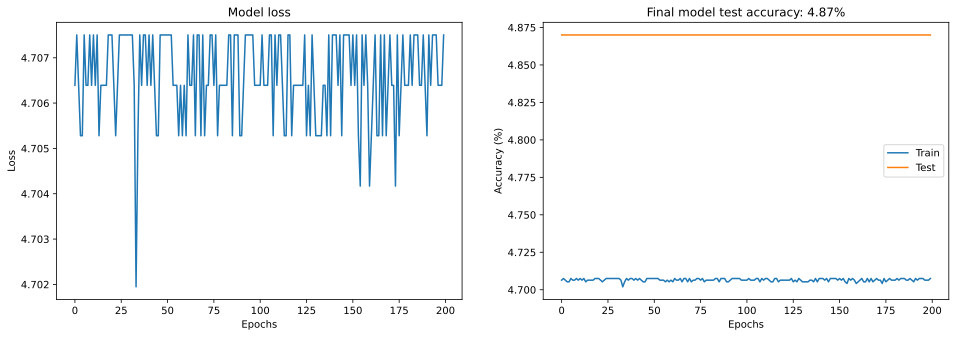

In [32]:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')

ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()